In [1]:
import nltk
from nltk.corpus import gutenberg
from string import punctuation

nltk.download("gutenberg")
nltk.download('punkt')
bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'


[nltk_data] Downloading package gutenberg to /home/weiteh/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /home/weiteh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# lower case all words and filter the punctuation and numbers
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]

In [3]:
norm_bible

[['the', 'king', 'james', 'bible'],
 ['the', 'old', 'testament', 'of', 'the', 'king', 'james', 'bible'],
 ['the', 'first', 'book', 'of', 'moses', 'called', 'genesis'],
 ['in',
  'the',
  'beginning',
  'god',
  'created',
  'the',
  'heaven',
  'and',
  'the',
  'earth'],
 ['and',
  'the',
  'earth',
  'was',
  'without',
  'form',
  'and',
  'void',
  'and',
  'darkness',
  'was',
  'upon',
  'the',
  'face',
  'of',
  'the',
  'deep'],
 ['and',
  'the',
  'spirit',
  'of',
  'god',
  'moved',
  'upon',
  'the',
  'face',
  'of',
  'the',
  'waters'],
 ['and',
  'god',
  'said',
  'let',
  'there',
  'be',
  'light',
  'and',
  'there',
  'was',
  'light'],
 ['and',
  'god',
  'saw',
  'the',
  'light',
  'that',
  'it',
  'was',
  'good',
  'and',
  'god',
  'divided',
  'the',
  'light',
  'from',
  'the',
  'darkness'],
 ['and',
  'god',
  'called',
  'the',
  'light',
  'day',
  'and',
  'the',
  'darkness',
  'he',
  'called',
  'night'],
 ['and',
  'the',
  'evening',
  'and',
 

In [4]:
norm_bible = [ " ".join(x) for x in norm_bible]

In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

wpt = nltk.WordPunctTokenizer()
nltk.download("stopwords")

stop_words = nltk.corpus.stopwords.words('english')
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to /home/weiteh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
norm_bible

['the king james bible',
 'the old testament of the king james bible',
 'the first book of moses called genesis',
 'in the beginning god created the heaven and the earth',
 'and the earth was without form and void and darkness was upon the face of the deep',
 'and the spirit of god moved upon the face of the waters',
 'and god said let there be light and there was light',
 'and god saw the light that it was good and god divided the light from the darkness',
 'and god called the light day and the darkness he called night',
 'and the evening and the morning were the first day',
 'and god said let there be a firmament in the midst of the waters and let it divide the waters from the waters',
 'and god made the firmament and divided the waters which were under the firmament from the waters which were above the firmament and it was so',
 'and god called the firmament heaven',
 'and the evening and the morning were the second day',
 'and god said let the waters under the heaven be gathered to

In [7]:
norm_bible = filter(None, normalize_corpus(norm_bible))

In [8]:
norm_bible

In [9]:
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

In [10]:
print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


![title](img/word2vec-cbow.png)

In [11]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()

Using TensorFlow backend.
/home/weiteh/word2vec/venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/weiteh/word2vec/venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/weiteh/word2vec/venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/weiteh/word2vec/venv/lib/python3.5/sit

In [12]:
tokenizer.fit_on_texts(norm_bible)

In [13]:
word2id = tokenizer.word_index

In [14]:
id2word = tokenizer.index_word

In [15]:
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

In [16]:
vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12424
Vocabulary Sample: [('zuph', 6074), ('allon', 7171), ('spindle', 10670), ('dissimulation', 8338), ('partaker', 3618), ('maaziah', 7505), ('adversities', 7231), ('magnificence', 11775), ('glutton', 7105), ('twentieth', 1430)]


In [17]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            try:
                y = np_utils.to_categorical(label_word, vocab_size)
                yield (x, y)
            except:
                for w in label_word:
                    print("Error occurred for: {}".format(w))
                raise
                

In [18]:
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light
Error occurred for: [232]


In [19]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

In [20]:
# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [21]:
# view model summary
print(cbow.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            1242400   
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12424)             1254824   
Total params: 2,497,224
Trainable params: 2,497,224
Non-trainable params: 0
_________________________________________________________________
None


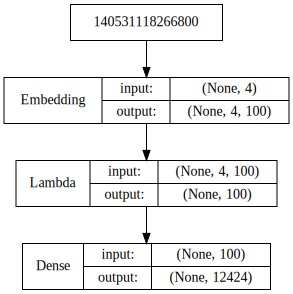

In [22]:
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [23]:
for epoch in range(1, 2):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Error occurred for: [12424]


IndexError: index 12424 is out of bounds for axis 1 with size 12424